In [1]:
!pip install matplotlib pyspark

In [2]:
!pip install chardet

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import chardet
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, count, sum

In [13]:
spark = SparkSession.builder \
    .appName("Publishing Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.extraJavaOptions", "-XX:+PrintGCDetails -XX:+PrintGCTimeStamps -Xloggc:/path/to/gc.log") \
    .getOrCreate()

In [14]:
csv_directory = ('../ARDataset/')
all_data = pd.DataFrame()
failed_files = []

In [15]:
def detect_encoding(file_path):
    """Detect the encoding of a file."""
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read(10000))  
    return result['encoding']

In [16]:
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_directory, filename)
        encoding = detect_encoding(file_path) 
        try:
            temp_data = pd.read_csv(file_path, encoding=encoding, on_bad_lines='skip')  # Skip bad lines
            all_data = pd.concat([all_data, temp_data], ignore_index=True)
            print(f"Loaded {filename} with encoding {encoding}")
        except Exception as e:
            print(f"Failed to load {filename} with detected encoding {encoding}: {e}")
            failed_files.append(filename) 

            try:
                temp_data = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')
                all_data = pd.concat([all_data, temp_data], ignore_index=True)
                print(f"Successfully loaded {filename} with fallback encoding ISO-8859-1")
            except Exception as e:
                print(f"Failed to load {filename} with fallback encoding: {e}")
                failed_files.append(filename) 

print("Data loaded:", all_data.shape)

Loaded part-00007-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00010-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00009-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00004-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00000-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00001-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00003-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00006-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00008-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00005-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00002-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encoding utf-8
Loaded part-00012-5e194d26-a8d2-4362-a3ba-8db470c839a8-c000.csv with encodin

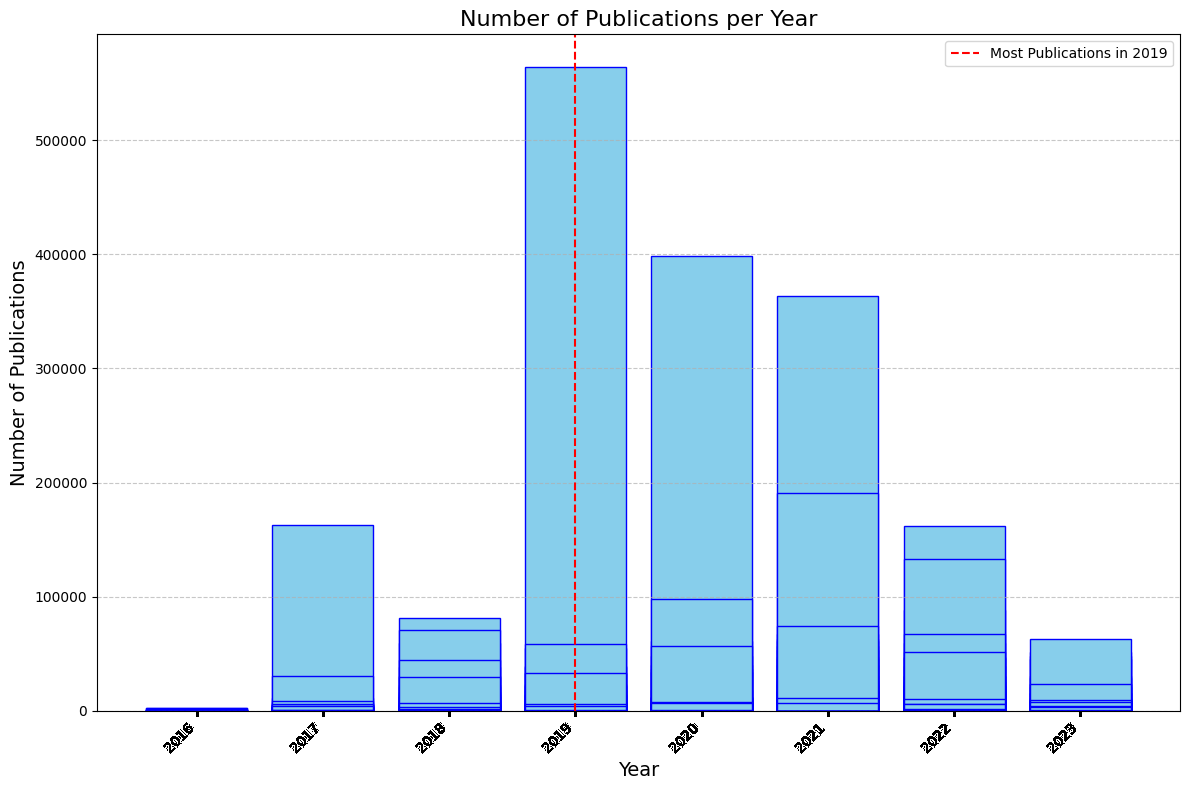

The year with the most publications is 2019 with 564419 publications.


In [20]:
if not all_data.empty and 'crawl_date' in all_data.columns and 'sitename' in all_data.columns:
    all_data['crawl_date'] = pd.to_datetime(all_data['crawl_date'], errors='coerce')

    all_data['year'] = all_data['crawl_date'].dt.year  

    publications_per_year = all_data.groupby(['year', 'sitename']).size().reset_index(name='publication_count')
    publications_per_year = publications_per_year[publications_per_year['year'] >= 2013]

    max_publications_year = publications_per_year.loc[publications_per_year['publication_count'].idxmax()]

    plt.figure(figsize=(12, 8))
    plt.bar(publications_per_year['year'], publications_per_year['publication_count'], color='skyblue', edgecolor='blue')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Publications', fontsize=14)
    plt.title('Number of Publications per Year', fontsize=16)

    plt.xticks(publications_per_year['year'], rotation=45, ha='right')

    plt.axvline(x=max_publications_year['year'], color='red', linestyle='--', label=f"Most Publications in {int(max_publications_year['year'])}")

    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"The year with the most publications is {int(max_publications_year['year'])} with {int(max_publications_year['publication_count'])} publications.")
else:
    print("The DataFrame is empty or does not contain the necessary columns.")
